In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets

In [2]:
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals1 = np.array([1 if y == 0 else -1 for y in iris.target])
y_vals2 = np.array([1 if y == 1 else -1 for y in iris.target])
y_vals3 = np.array([1 if y == 2 else -1 for y in iris.target])
y_vals = np.array([y_vals1, y_vals2, y_vals3])
class1_x = [x[0] for i, x in enumerate(x_vals) if iris.target[i] == 0]
class1_y = [x[1] for i, x in enumerate(x_vals) if iris.target[i] == 0]
class2_x = [x[0] for i, x in enumerate(x_vals) if iris.target[i] == 1]
class2_y = [x[1] for i, x in enumerate(x_vals) if iris.target[i] == 1]
class3_x = [x[0] for i, x in enumerate(x_vals) if iris.target[i] == 2]
class3_y = [x[1] for i, x in enumerate(x_vals) if iris.target[i] == 2]

In [5]:
with tf.Session() as sess:
    bs = 50
    lr = 0.01
    it = 100
    x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
    y_target = tf.placeholder(shape=[3, None], dtype=tf.float32)
    prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)
    
    b = tf.Variable(tf.random_normal(shape=[3, bs]))
    
    gamma = tf.constant(-10.0)
    dist = tf.reduce_sum(tf.square(x_data), 1)
    dist = tf.reshape(dist, [-1, 1])
    sq_dists = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
    my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))
    
    def reshape_matmul(mat):
        v1 = tf.expand_dims(mat, 1)
        v2 = tf.reshape(v1, [3, bs, 1])
        return(tf.matmul(v2, v1))
    
    first_term = tf.reduce_sum(b)
    b_vec_cross = tf.matmul(tf.transpose(b), b)
    y_target_cross = reshape_matmul(y_target)
    second_term = tf.reduce_sum(tf.multiply(my_kernel,
                                tf.multiply(b_vec_cross, y_target_cross)), [1, 2])
    loss = tf.reduce_sum(tf.negative(tf.subtract(first_term, second_term)))
    
    rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1, 1])
    rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1, 1])
    pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2.,
                   tf.matmul(x_data, tf.transpose(prediction_grid)))),
                   tf.transpose(rB))
    pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))
    
    prediction_output = tf.matmul(tf.multiply(y_target, b), pred_kernel)
    prediction = tf.argmax(prediction_output - tf.expand_dims(
                           tf.reduce_mean(prediction_output, 1), 1), 0)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction,
                                      tf.argmax(y_target, 0)), tf.float32))
    
    my_opt = tf.train.GradientDescentOptimizer(lr)
    train_step = my_opt.minimize(loss)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    loss_vec = []
    batch_accuracy = []
    for i in range(it):
        rand_index = np.random.choice(len(x_vals), size=bs)
        rand_x = x_vals[rand_index]
        rand_y = y_vals[:, rand_index]
        sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
        temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
        loss_vec.append(temp_loss)
        acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                                 y_target: rand_y,
                                                 prediction_grid: rand_x})
        batch_accuracy.append(acc_temp)
    
        if (i + 1) % 25 == 0:
            print('Step #' + str(i + 1))
            print('Loss = ' + str(temp_loss))
    
    x_min, x_max, = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
    y_min, y_max, = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_predictions = sess.run(prediction, feed_dict={
        x_data: rand_x,
        y_target: rand_y,
        prediction_grid: grid_points
    })
    grid_predictions = grid_predictions.reshape(xx.shape)

Step #25
Loss = -360.1022
Step #50
Loss = -697.602
Step #75
Loss = -1035.1016
Step #100
Loss = -1372.6016


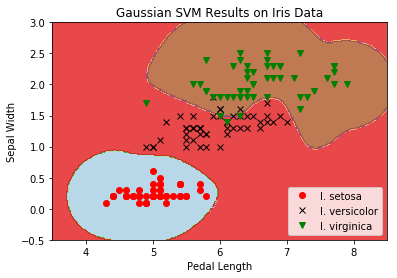

In [6]:
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y, 'kx', label='I. versicolor')
plt.plot(class3_x, class3_y, 'gv', label='I. virginica')
plt.title('Gaussian SVM Results on Iris Data')
plt.xlabel('Pedal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()

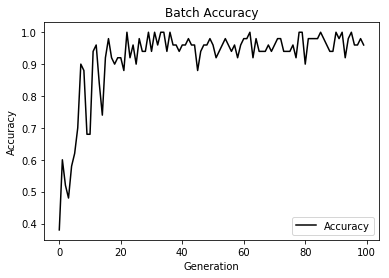

In [7]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

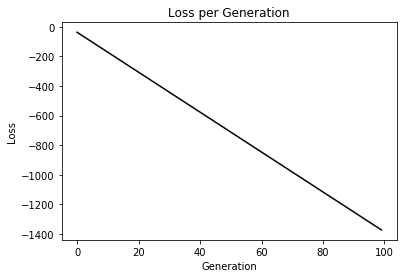

In [8]:
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()